$\textbf{x}\in\Omega$

$$\nabla\cdot\textbf{u} = 0$$
$$\textbf{0}=-\nabla p + \nabla^2\textbf{u} + \textbf{f}$$

$\textbf{x}\in\partial\Omega_E$ essential boundary condition

$$\textbf{u} = \textbf{u}_{\text{D}}$$

$\textbf{x}\in\partial\Omega_{	ext{N}}$ natural boundary condition

$$p = p_{\text{N}}$$

variational form

$$\int_\Omega\text{d}x~q(\nabla\cdot\textbf{u}) - p(\nabla\cdot\textbf{v}) + \mu\nabla\textbf{v}\cdot\nabla\textbf{u} - \textbf{v}\cdot\textbf{f} + \int_{\partial\Omega_{	ext{N}}}\text{d}s~p\,\textbf{v}\cdot\textbf{n}$$

In [18]:
import numpy as np
from ufl.core.expr import Expr
from ufl import (Form, FacetNormal, CellDiameter, dx, dS,
    TestFunction, TrialFunction, TestFunctions, TrialFunctions,
    inner, grad, div, avg, jump, Dx, as_matrix,
)

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import bvp_solver, interpolation_solver, BoundaryConditions, OptionsPETSc
from lucifex.utils import cross_section, fem_function_components
from lucifex.viz import plot_colormap, plot_line, plot_streamlines


def stokes(
    up: Function,
    f: Function | Constant | None = None,
    bcs: BoundaryConditions | None = None
) -> list[Form]:
    v, q = TestFunctions(up.function_space)
    u, p = TrialFunctions(up.function_space)
    n = FacetNormal(up.function_space.mesh) 

    F_incomp = q * div(u) * dx
    F_velocity = inner(grad(v), grad(u)) * dx
    F_pressure = -p * div(v) * dx

    if f is None:
        f = Constant(up.function_space.mesh, 0.0, shape=u.ufl_shape)
    F_force = -inner(v, f) * dx

    forms = [F_incomp, F_velocity, F_pressure, F_force]

    if bcs is not None:
        ds, p_natural =  bcs.boundary_data(up.function_space, 'natural')
        F_bcs = sum([inner(v, n) * pN * ds(i) for i, pN in p_natural])
        forms.append(F_bcs)

    return forms

### Poiseuille Flow

In [ ]:
Lx = 2.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 200, 200, cell='right')
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
        "lower": lambda x: x[1],
        "upper": lambda x: x[1] - Ly,
    },
)

u_elem = ('P', 2, 2)
p_elem = ('P', 1)
u_p_elem = [u_elem, p_elem]
up = Function((mesh, u_p_elem), name="up")

bcs = BoundaryConditions(
    ('essential', boundary['upper', 'lower'], (0.0, 0.0), 0),
)
p_bcs = BoundaryConditions(
    ('natural', boundary['left'], 1.0, 1),
    ('natural', boundary['right'], 0.0, 1),
)

petsc = OptionsPETSc.default()
petsc['pc_factor_mat_solver_type'] = 'mumps'
up_solver = bvp_solver(stokes, bcs, petsc)(up, bcs=p_bcs)
up_solver.solve()

u, p = up.split(('u', 'p'), collapse=True)
ux, uy = fem_function_components(('P', 1), u, names=('ux', 'uy'))

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$y$', ylabel='$u_x(x=1.00)$'>)

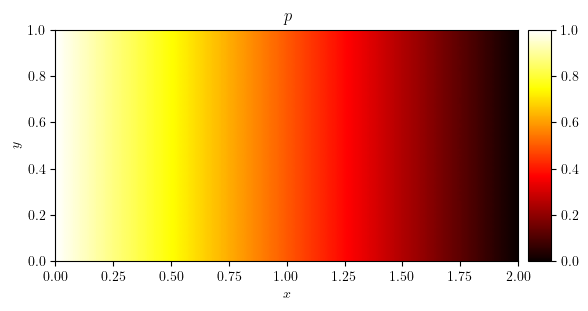

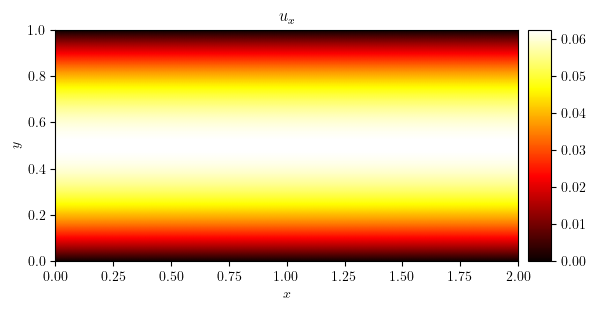

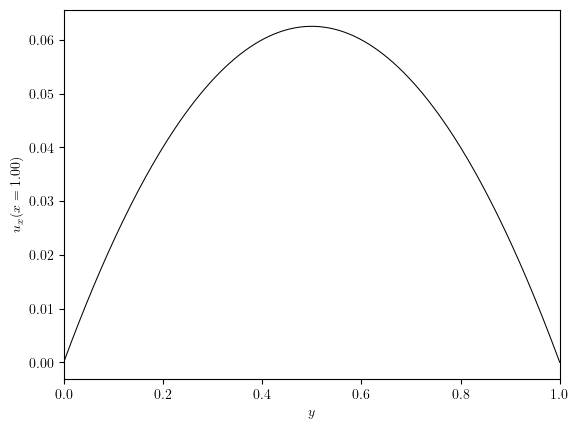

In [5]:
plot_colormap(p, title=f'${p.name}$')

plot_colormap(ux, title=f'${u.name}_x$')

x_axis, ux_x, y_value = cross_section(ux, 'x', 0.5)
plot_line((x_axis, ux_x), x_label='$y$', y_label=f'${u.name}_x(x={y_value:.2f})$')

### Lid-Driven Cavity

In [ ]:
Lx = 1.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 100, 100, cell='quadrilateral')
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
        "lower": lambda x: x[1],
        "upper": lambda x: x[1] - Ly,
    },
)

u_elem = ('P', 2, 2)
p_elem = ('P', 1)
u_p_elem = [u_elem, p_elem]
up = Function((mesh, u_p_elem), name="up")

u_lid = 1.0
bcs = BoundaryConditions(
    ('essential', boundary['upper'], (u_lid, 0.0), 0),
    ('essential', boundary['left', 'right', 'lower'], (0.0, 0.0), 0),
)

petsc = OptionsPETSc.default()
petsc['pc_factor_mat_solver_type'] = 'mumps'
up_solver = bvp_solver(stokes, bcs, petsc)(up)
up_solver.solve()

u, p = up.split(('u', 'p'), collapse=True)
ux, uy = fem_function_components(('P', 1), u, names=('ux', 'uy'))

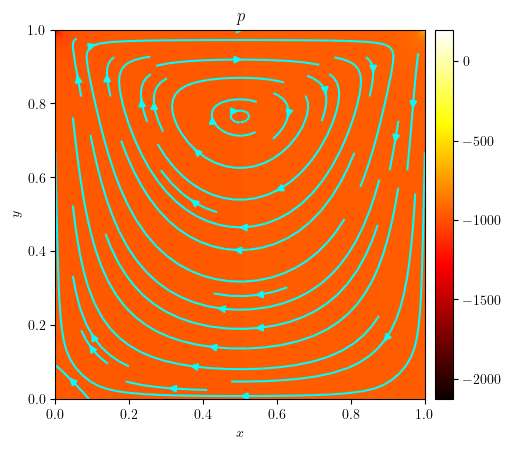

In [7]:
fig, ax = plot_colormap(p, title='$p$', x_label='$x$', y_label='$y$')
plot_streamlines(fig, ax, (ux, uy), density=0.75, color='cyan')

### Streamfunction Formulation

$\textbf{x}\in\Omega$ 

$$\textbf{u}=\bigg(-\frac{\partial\psi}{\partial y}, \frac{\partial\psi}{\partial x}\bigg)~,~\textbf{f}=f\textbf{e}_y\iff \nabla^2(\nabla^2\psi) = \frac{\partial f}{\partial x}$$

$\textbf{x}\in\partial\Omega$

$$\textbf{n}\cdot\textbf{u}=0 \iff \psi=0$$

$$\textbf{n}\cdot\nabla(\textbf{t}\cdot\textbf{u})=0 \iff \nabla^2\psi=0$$

In [23]:
def stokes_streamfunction(
    psi: Function,
    f: Function | None = None,
    alpha: Constant | None = None,
) -> list[Form]:
    v = TestFunction(psi.function_space)
    psi_trial = TrialFunction(psi.function_space)
    n = FacetNormal(psi.function_space.mesh)
    h = CellDiameter(psi.function_space.mesh)

    F_dx = div(grad(v)) * div(grad(psi_trial)) * dx

    F_dS = (alpha / avg(h)) * inner(jump(grad(v), n), jump(grad(psi_trial), n)) * dS
    F_dS -= inner(jump(grad(v), n), avg(div(grad(psi_trial)))) * dS
    F_dS -= inner(avg(div(grad(v))), jump(grad(psi_trial), n)) * dS

    F_force = -v * Dx(f, 0) * dx

    return [F_dx, F_dS, F_force]


def streamfunction_velocity(psi: Function) -> Expr:
    return as_matrix([[0, 1], [-1, 0]]) * grad(psi)


f = Function(
    (mesh, 'P', 1), 
    lambda x: 5 * x[1] * np.sin(6 * np.pi * x[0] / Lx),
    name='f',
)
alpha = Constant(mesh, 8.0, name='alpha')

bcs = BoundaryConditions(
    ('essential', boundary.union, 0.0),
)

psi = Function((mesh, 'P', 2), name="psi")
psi_solver = bvp_solver(stokes_streamfunction, bcs)(psi, f, alpha)
psi_solver.solve()

u = Function((mesh, 'P', 1, 2), name='u')
u_solver = interpolation_solver(u, streamfunction_velocity)(psi)
u_solver.solve()

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$y$', ylabel='$u_y(y=0.50)$'>)

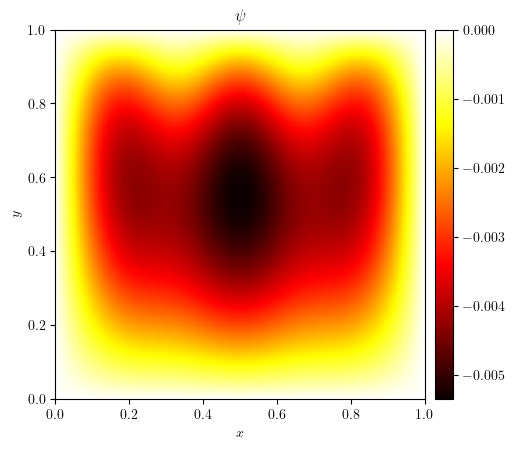

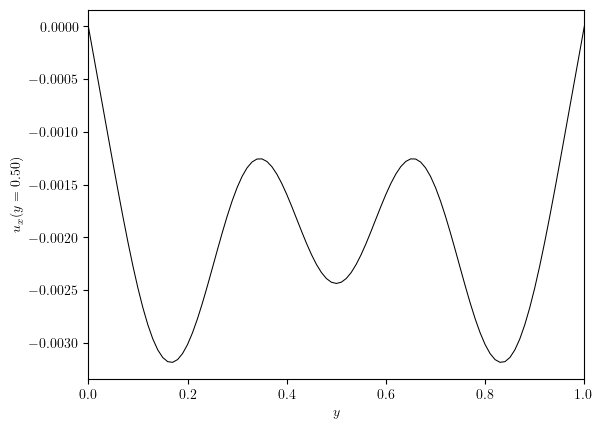

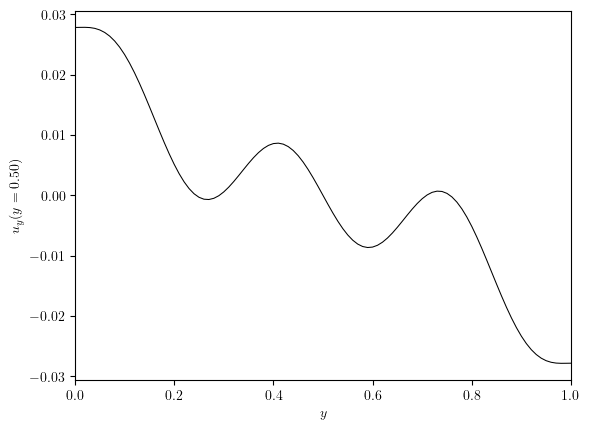

: 

In [ ]:
plot_colormap(psi, title='$\psi$', x_label='$x$', y_label='$y$')

ux, uy = fem_function_components(('P', 1), u, names=('ux', 'uy'))

x_axis, ux_x, y_value = cross_section(ux, 'y', 0.5)
plot_line((x_axis, ux_x), x_label='$y$', y_label=f'${u.name}_x(y={y_value:.2f})$')

x_axis, uy_x, y_value = cross_section(uy, 'y', 0.5)
plot_line((x_axis, uy_x), x_label='$y$', y_label=f'${u.name}_y(y={y_value:.2f})$')
